## Baseline for the vanilla federated learning approach using FedAvg

In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Render plots inline
%matplotlib inline

BASE_DIR = "data/brisc2025/"

In [2]:
import numpy as np
import wandb
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
import shutil
import os                              # Import the 'os' module for changing directories
os.chdir('/content/drive/MyDrive/BRISC2025_FL')  # Change the directory

Mounted at /content/drive


In [3]:
# In[2] — Directory Tree
def walk_dir(base, max_depth=2):
    for root, dirs, _ in os.walk(base):
        depth = root.replace(base, "").count(os.sep)
        if depth <= max_depth:
            indent = "  " * depth
            print(f"{indent}{os.path.basename(root)}/")
            for d in dirs:
                print(f"{indent}  {d}/")

print("## BRISC2025 Folder Layout:")
walk_dir(BASE_DIR, max_depth=2)

## BRISC2025 Folder Layout:
/
  segmentation_task/
  classification_task/
segmentation_task/
  test/
  train/
  test/
    masks/
    images/
    masks/
    images/
  train/
    images/
    masks/
    images/
    masks/
classification_task/
  train/
  test/
  train/
    no_tumor/
    glioma/
    pituitary/
    meningioma/
    no_tumor/
    glioma/
    pituitary/
    meningioma/
  test/
    no_tumor/
    meningioma/
    pituitary/
    glioma/
    no_tumor/
    meningioma/
    pituitary/
    glioma/


In [4]:
import os
import glob
import pandas as pd

# Function to get all file paths matching a pattern
def get_file_paths(patterns):
    files = []
    for p in patterns:
        files.extend(glob.glob(p))
    return files

# Classification
splits = ["test", "train"]
classes = ["glioma", "meningioma", "pituitary", "no_tumor"]

cls_records = []
file_paths_list = []  # store actual file paths

for sp in splits:
    total_files = []
    for cls in classes:
        pat = os.path.join(BASE_DIR, "classification_task", sp, cls, "*.jpg")
        files = get_file_paths([pat])
        cls_records.append({'Split': sp, 'Class': cls, 'Count': len(files)})
        total_files.extend(files)
        file_paths_list.extend(files)  # add to global list
    cls_records.append({'Split': sp, 'Class': 'Total', 'Count': len(total_files)})

# Convert to DataFrame for display
df_cls = pd.DataFrame(cls_records)

# Display counts
print("### Classification Counts")
display(df_cls)

# file_paths_list now contains all paths
print(f"Total number of image paths collected: {len(file_paths_list)}")


### Classification Counts


,Split,Class,Count
0,test,glioma,254
1,test,meningioma,306
2,test,pituitary,300
3,test,no_tumor,140
4,test,Total,1000
5,train,glioma,1147
6,train,meningioma,1329
7,train,pituitary,1457
8,train,no_tumor,1067
9,train,Total,5000


Total number of image paths collected: 6000


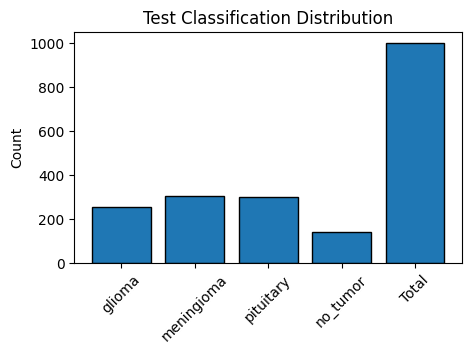

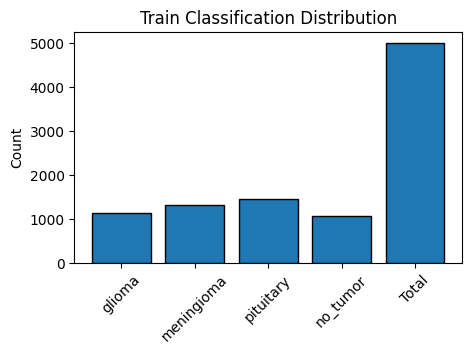

In [5]:
# In[4] — Distribution Plots
for sp in splits:
    sub = df_cls[df_cls.Split==sp]
    plt.figure(figsize=(5,3))
    plt.bar(sub.Class, sub.Count, edgecolor='k')
    plt.title(f"{sp.title()} Classification Distribution")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

In [7]:
import glob

def count_patterns(patterns):
    """
    Count the total number of files matching one or more glob patterns.

    Parameters
    ----------
    patterns : list of str
        List of glob-style file path patterns (e.g., ['path/to/files/*.jpg']).

    Returns
    -------
    int
        Total number of files matching the provided patterns.
    """
    total_count = 0
    for pat in patterns:
        matches = glob.glob(pat)
        total_count += len(matches)
    return total_count


An important feature of this dataset is the inclusion of multi-
ple imaging perspectives for each tumor, covering the
Coronal, Sagittal, and Axial planes. This comprehensive approach captures a diverse range of tumor char-
acteristics, enabling researchers to train models that
generalize well across different views.

In [8]:
# In[5] — Per‑Plane Counts
planes = ["ax", "co", "sa"]
plane_records = []

for sp in splits:
    for cls in classes:
        for pl in planes:
            pat = os.path.join(
                BASE_DIR, "classification_task", sp, cls, f"*_{pl}_t1.jpg"
            )
            cnt = count_patterns([pat])
            plane_records.append({'Split': sp, 'Class': cls, 'Plane': pl, 'Count': cnt})

df_plane = pd.DataFrame(plane_records)
print("### Per‑Plane Counts Pivot")
display(df_plane.pivot_table(index='Plane', columns=['Split','Class'], values='Count'))

### Per‑Plane Counts Pivot


Split   test                                train                      \
Class glioma meningioma no_tumor pituitary glioma meningioma no_tumor   
Plane                                                                   
ax      85.0      137.0     52.0     124.0  394.0      423.0    352.0   
co      81.0       86.0     48.0      90.0  430.0      426.0    310.0   
sa      88.0       83.0     40.0      86.0  323.0      480.0    405.0   

Split            
Class pituitary  
Plane            
ax        426.0  
co        510.0  
sa        521.0

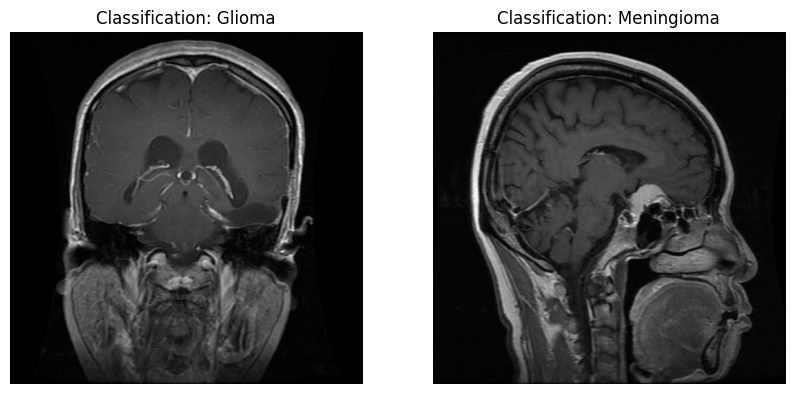

In [9]:
# In[6] — Sample Visualization
def first_file(folder, exts):
    for ext in exts:
        fl = glob.glob(os.path.join(folder, f"*.{ext}"))
        if fl: return fl[0]
    return None

img_path  = first_file(os.path.join(BASE_DIR, "classification_task/train/glioma"), ["jpg"])
img2_path = first_file(os.path.join(BASE_DIR, "classification_task/train/meningioma"), ["jpg"])
img  = Image.open(img_path)
img2 = Image.open(img2_path)


fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(img,  cmap="gray"); axes[0].set_title("Classification: Glioma"); axes[0].axis("off")
axes[1].imshow(img2,  cmap="gray"); axes[1].set_title("Classification: Meningioma"); axes[1].axis("off")

plt.show()

In [10]:
# In[8] — Metadata Table
meta = []
for sp in splits:
    for cls in classes:
        files = glob.glob(os.path.join(BASE_DIR, "classification_task", sp, cls, "*.jpg"))
        for f in files:
            parts = os.path.basename(f).split("_")
            meta.append({
                "Filename": os.path.basename(f),
                "Split": parts[1],
                "Index": parts[2],
                "Tumor": parts[3],
                "Plane": parts[4],
                "Sequence": parts[5].split(".")[0]
            })
df_meta = pd.DataFrame(meta)
print("### Sample Filename Metadata")
display(df_meta)

### Sample Filename Metadata


,Filename,Split,Index,Tumor,Plane,Sequence
0,brisc2025_test_00079_gl_ax_t1.jpg,test,00079,gl,ax,t1
1,brisc2025_test_00065_gl_ax_t1.jpg,test,00065,gl,ax,t1
2,brisc2025_test_00042_gl_ax_t1.jpg,test,00042,gl,ax,t1
3,brisc2025_test_00041_gl_ax_t1.jpg,test,00041,gl,ax,t1
4,brisc2025_test_00063_gl_ax_t1.jpg,test,00063,gl,ax,t1
...,...,...,...,...,...,...
5995,brisc2025_train_03008_no_co_t1.jpg,train,03008,no,co,t1
5996,brisc2025_train_03395_no_sa_t1.jpg,train,03395,no,sa,t1
5997,brisc2025_train_02891_no_co_t1.jpg,train,02891,no,co,t1
5998,brisc2025_train_03063_no_co_t1.jpg,train,03063,no,co,t1


In [11]:
# Create mapping dictionary
tumor_map = {
    "gl": "glioma",
    "me": "meningioma",
    "pi": "pituitary",
    "no": "no_tumor"
}

# Apply mapping to the DataFrame
df_meta["Tumor"] = df_meta["Tumor"].map(tumor_map)

print("### Sample Filename Metadata (with full tumor names)")
display(df_meta)


### Sample Filename Metadata (with full tumor names)


,Filename,Split,Index,Tumor,Plane,Sequence
0,brisc2025_test_00079_gl_ax_t1.jpg,test,00079,glioma,ax,t1
1,brisc2025_test_00065_gl_ax_t1.jpg,test,00065,glioma,ax,t1
2,brisc2025_test_00042_gl_ax_t1.jpg,test,00042,glioma,ax,t1
3,brisc2025_test_00041_gl_ax_t1.jpg,test,00041,glioma,ax,t1
4,brisc2025_test_00063_gl_ax_t1.jpg,test,00063,glioma,ax,t1
...,...,...,...,...,...,...
5995,brisc2025_train_03008_no_co_t1.jpg,train,03008,no_tumor,co,t1
5996,brisc2025_train_03395_no_sa_t1.jpg,train,03395,no_tumor,sa,t1
5997,brisc2025_train_02891_no_co_t1.jpg,train,02891,no_tumor,co,t1
5998,brisc2025_train_03063_no_co_t1.jpg,train,03063,no_tumor,co,t1


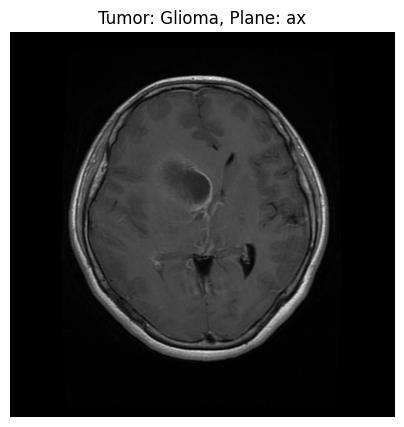

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# Example: pick the row for a specific filename
row = df_meta[df_meta['Filename'] == "brisc2025_test_00079_gl_ax_t1.jpg"].iloc[0]

# Build the full path
img_path = os.path.join(BASE_DIR, "classification_task", row["Split"], row["Tumor"], row['Filename'])

# Open and display the image
img = Image.open(img_path)

plt.figure(figsize=(5,5))
plt.imshow(img, cmap="gray")
plt.title(f"Tumor: {row['Tumor'].capitalize()}, Plane: {row['Plane']}")
plt.axis("off")
plt.show()

In [13]:
def show_filenames_by_filters(df, plane=None, tumor=None, split=None):
    """
    Filter and display filenames from df_meta based on plane, tumor, and split.

    Args:
        df (pd.DataFrame): The metadata dataframe.
        plane (str, optional): Plane filter ('ax', 'co', 'sa').
        tumor (str, optional): Tumor type filter ('glioma', 'meningioma', 'pituitary', 'no_tumor').
        split (str, optional): Data split ('train' or 'test').

    Returns:
        pd.Series: The list of matching filenames.
    """
    filtered = df.copy()

    if plane:
        filtered = filtered[filtered['Plane'] == plane]
    if tumor:
        filtered = filtered[filtered['Tumor'] == tumor]
    if split:
        filtered = filtered[filtered['Split'] == split]

    if filtered.empty:
        print("⚠️ No images found for the given filters.")
        return None

    print(f"✅ Found {len(filtered)} image(s) matching your filters:")
    #display(filtered[['Filename', 'Split', 'Tumor', 'Plane']])

    return filtered['Filename']


In [14]:
display(show_filenames_by_filters(df_meta, plane="co", tumor="glioma", split="train"))

✅ Found 430 image(s) matching your filters:


,Filename
1000,brisc2025_train_00713_gl_co_t1.jpg
1003,brisc2025_train_00796_gl_co_t1.jpg
1005,brisc2025_train_00458_gl_co_t1.jpg
1006,brisc2025_train_00765_gl_co_t1.jpg
1008,brisc2025_train_00824_gl_co_t1.jpg
...,...
2141,brisc2025_train_00681_gl_co_t1.jpg
2142,brisc2025_train_00782_gl_co_t1.jpg
2143,brisc2025_train_00413_gl_co_t1.jpg
2144,brisc2025_train_00617_gl_co_t1.jpg


In [15]:
filenames_gl_co_train = show_filenames_by_filters(df_meta, plane="co", tumor="glioma", split="train")
filenames_me_co_train = show_filenames_by_filters(df_meta, plane="co", tumor="meningioma", split="train")
filenames_pi_co_train = show_filenames_by_filters(df_meta, plane="co", tumor="pituitary", split="train")
filenames_no_co_train = show_filenames_by_filters(df_meta, plane="co", tumor="no_tumor", split="train")

✅ Found 430 image(s) matching your filters:
✅ Found 426 image(s) matching your filters:
✅ Found 510 image(s) matching your filters:
✅ Found 310 image(s) matching your filters:


In [16]:
img_path_gl_co = os.path.join(BASE_DIR, "classification_task", "train", "glioma", filenames_gl_co_train.values[0])


In [17]:
img_path_gl_co = os.path.join(BASE_DIR, "classification_task", "train", "glioma", filenames_gl_co_train.values[0])
img_path_me_co = os.path.join(BASE_DIR, "classification_task", "train", "meningioma", filenames_me_co_train.values[0])
img_path_pi_co = os.path.join(BASE_DIR, "classification_task", "train", "pituitary", filenames_pi_co_train.values[0])
img_path_no_co = os.path.join(BASE_DIR, "classification_task", "train", "no_tumor", filenames_no_co_train.values[0])

img_gl_co = Image.open(img_path_gl_co)
img_me_co = Image.open(img_path_me_co)
img_pi_co = Image.open(img_path_pi_co)
img_no_co = Image.open(img_path_no_co)


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

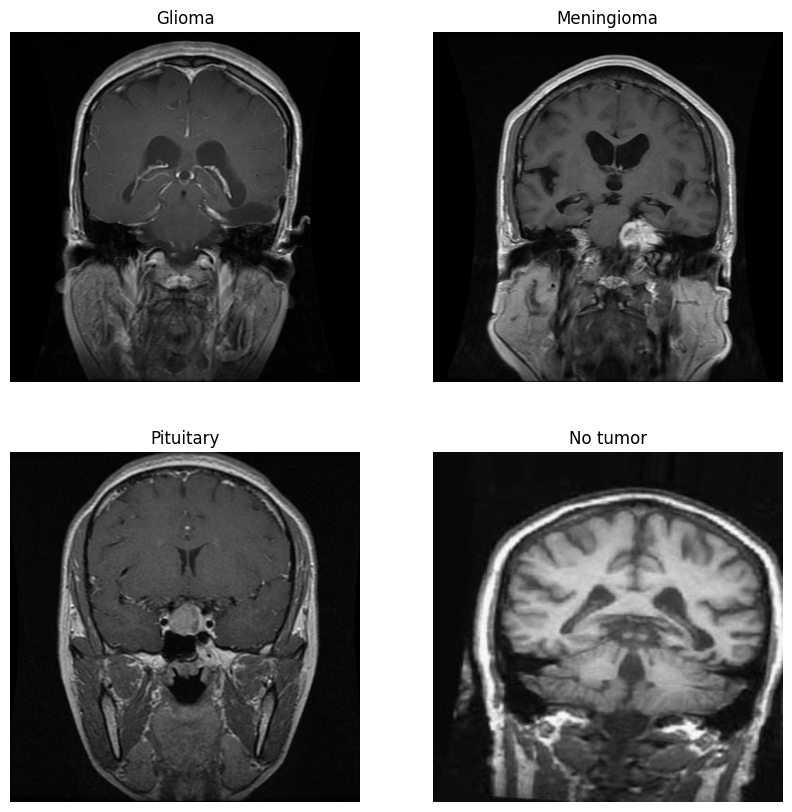

In [18]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
axes[0,0].imshow(img_gl_co, cmap="gray"); axes[0,0].set_title("Glioma"); axes[0,0].axis("off")
axes[0,1].imshow(img_me_co, cmap="gray"); axes[0,1].set_title("Meningioma"); axes[0,1].axis("off")
axes[1,0].imshow(img_pi_co, cmap="gray"); axes[1,0].set_title("Pituitary"); axes[1,0].axis("off")
axes[1,1].imshow(img_no_co, cmap="gray"); axes[1,1].set_title("No tumor"); axes[1,1].axis("off")

In [19]:
gl_co_train_counts = len(filenames_gl_co_train)
me_co_train_counts = len(filenames_me_co_train)
pi_co_train_counts = len(filenames_pi_co_train)
no_co_train_counts = len(filenames_no_co_train)

In [20]:
filenames_gl_ax_train = show_filenames_by_filters(df_meta, plane="ax", tumor="glioma", split="train")
filenames_me_ax_train = show_filenames_by_filters(df_meta, plane="ax", tumor="meningioma", split="train")
filenames_pi_ax_train = show_filenames_by_filters(df_meta, plane="ax", tumor="pituitary", split="train")
filenames_no_ax_train = show_filenames_by_filters(df_meta, plane="ax", tumor="no_tumor", split="train")

gl_ax_train_counts = len(filenames_gl_ax_train)
me_ax_train_counts = len(filenames_me_ax_train)
pi_ax_train_counts = len(filenames_pi_ax_train)
no_ax_train_counts = len(filenames_no_ax_train)

✅ Found 394 image(s) matching your filters:
✅ Found 423 image(s) matching your filters:
✅ Found 426 image(s) matching your filters:
✅ Found 352 image(s) matching your filters:


In [21]:
filenames_gl_sa_train = show_filenames_by_filters(df_meta, plane="sa", tumor="glioma", split="train")
filenames_me_sa_train = show_filenames_by_filters(df_meta, plane="sa", tumor="meningioma", split="train")
filenames_pi_sa_train = show_filenames_by_filters(df_meta, plane="sa", tumor="pituitary", split="train")
filenames_no_sa_train = show_filenames_by_filters(df_meta, plane="sa", tumor="no_tumor", split="train")

gl_sa_train_counts = len(filenames_gl_sa_train)
me_sa_train_counts = len(filenames_me_sa_train)
pi_sa_train_counts = len(filenames_pi_sa_train)
no_sa_train_counts = len(filenames_no_sa_train)

✅ Found 323 image(s) matching your filters:
✅ Found 480 image(s) matching your filters:
✅ Found 521 image(s) matching your filters:
✅ Found 405 image(s) matching your filters:


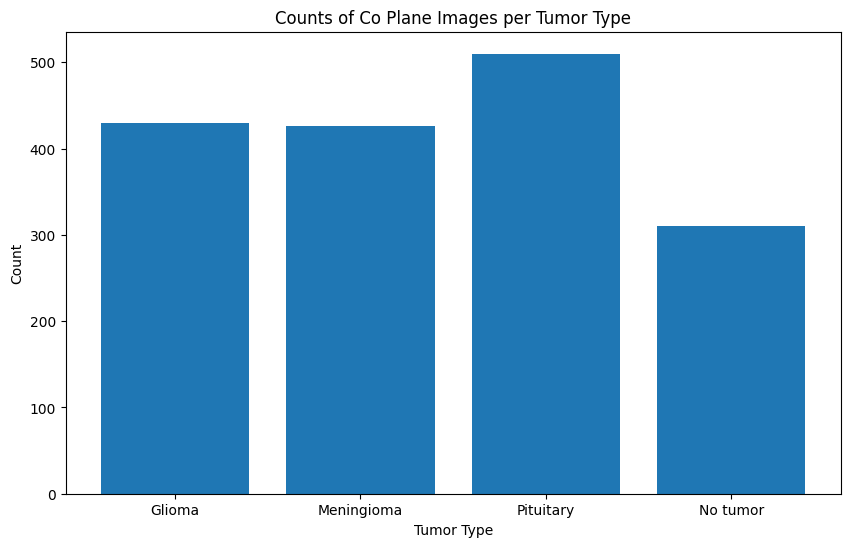

In [22]:
plt.subplots(figsize=(10,6))
plt.bar(["Glioma", "Meningioma", "Pituitary", "No tumor"], [gl_co_train_counts, me_co_train_counts, pi_co_train_counts, no_co_train_counts])
plt.title("Counts of Co Plane Images per Tumor Type")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

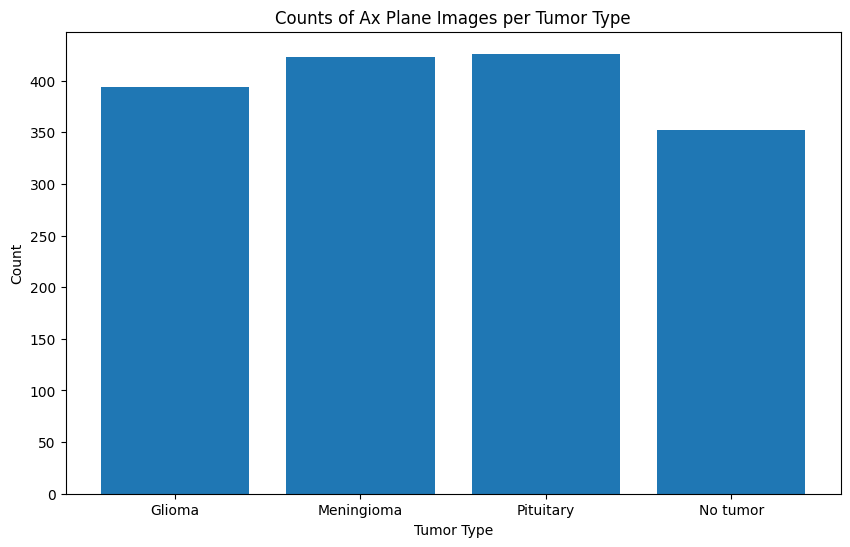

In [23]:
plt.subplots(figsize=(10,6))
plt.bar(["Glioma", "Meningioma", "Pituitary", "No tumor"], [gl_ax_train_counts, me_ax_train_counts, pi_ax_train_counts, no_ax_train_counts])
plt.title("Counts of Ax Plane Images per Tumor Type")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

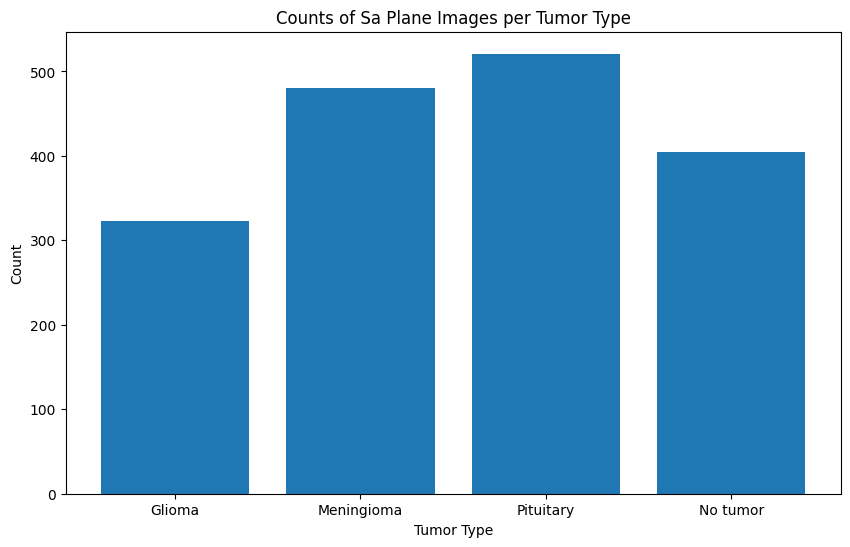

In [24]:
plt.subplots(figsize=(10,6))
plt.bar(["Glioma", "Meningioma", "Pituitary", "No tumor"], [gl_sa_train_counts, me_sa_train_counts, pi_sa_train_counts, no_sa_train_counts])
plt.title("Counts of Sa Plane Images per Tumor Type")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

In [25]:
df_meta["strata"] = df_meta["Tumor"] + "_" + df_meta["Plane"]

In [26]:
df_train = df_meta[df_meta["Split"] == "train"]

In [27]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df_train, test_size=0.2, stratify = df_train["strata"], random_state=42)

In [28]:
train

,Filename,Split,Index,Tumor,Plane,Sequence,strata
1467,brisc2025_train_00452_gl_co_t1.jpg,train,00452,glioma,co,t1,glioma_co
4227,brisc2025_train_04634_pi_sa_t1.jpg,train,04634,pituitary,sa,t1,pituitary_sa
2135,brisc2025_train_00574_gl_co_t1.jpg,train,00574,glioma,co,t1,glioma_co
2196,brisc2025_train_01546_me_ax_t1.jpg,train,01546,meningioma,ax,t1,meningioma_ax
5347,brisc2025_train_02742_no_ax_t1.jpg,train,02742,no_tumor,ax,t1,no_tumor_ax
...,...,...,...,...,...,...,...
4398,brisc2025_train_04958_pi_sa_t1.jpg,train,04958,pituitary,sa,t1,pituitary_sa
3527,brisc2025_train_03801_pi_ax_t1.jpg,train,03801,pituitary,ax,t1,pituitary_ax
4452,brisc2025_train_04650_pi_sa_t1.jpg,train,04650,pituitary,sa,t1,pituitary_sa
5066,brisc2025_train_02598_no_ax_t1.jpg,train,02598,no_tumor,ax,t1,no_tumor_ax


In [29]:
train_counts = train["strata"].value_counts()
val_counts = val["strata"].value_counts()

In [30]:
train_counts, val_counts

(strata
 pituitary_sa     417
 pituitary_co     408
 meningioma_sa    384
 glioma_co        344
 meningioma_co    341
 pituitary_ax     341
 meningioma_ax    338
 no_tumor_sa      324
 glioma_ax        315
 no_tumor_ax      282
 glioma_sa        258
 no_tumor_co      248
 Name: count, dtype: int64,
 strata
 pituitary_sa     104
 pituitary_co     102
 meningioma_sa     96
 glioma_co         86
 pituitary_ax      85
 meningioma_co     85
 meningioma_ax     85
 no_tumor_sa       81
 glioma_ax         79
 no_tumor_ax       70
 glioma_sa         65
 no_tumor_co       62
 Name: count, dtype: int64)

Dataset is balanced, I made the split from the train and evaluation so I can conduct a better analysis without overfitting. Let's think about what could I use for that and create a centralized baseline and then see how it changes in the Federated Learning setup

In [31]:
from torchvision import datasets, transforms

img_path = os.path.join(BASE_DIR, "classification_task", "train", "glioma", filenames_gl_co_train.values[0])


In [32]:
transform = transforms.ToTensor()
img_tensor = transform(Image.open(img_path).convert("RGB"))

print("Tensor shape:", img_tensor.shape)

Tensor shape: torch.Size([3, 512, 512])


In [33]:
import os
from PIL import Image
from torchvision import transforms

def check_image_shapes(folder_path, target_shape=(3, 512, 512)):
    """
    Checks all .jpg images in a folder (and subfolders) for shape mismatches.

    Args:
        folder_path (str): Path to the dataset directory.
        target_shape (tuple): Expected (C, H, W) shape.

    Returns:
        list: List of (filepath, actual_shape) for mismatched images.
    """
    transform = transforms.ToTensor()
    mismatched = []

    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(".jpg"):
                path = os.path.join(root, file)
                try:
                    img = Image.open(path).convert("RGB")
                    tensor = transform(img)
                    if tensor.shape != target_shape:
                        mismatched.append((path, tuple(tensor.shape)))
                except Exception as e:
                    print(f"⚠️ Error reading {path}: {e}")

    if mismatched:
        print(f"\nFound {len(mismatched)} images with shape different from {target_shape}:")
        for path, shape in mismatched[:10]:  # show first 10 only
            print(f" - {path}: {shape}")
        if len(mismatched) > 10:
            print(f"...and {len(mismatched)-10} more.")
    else:
        print(f"✅ All images match {target_shape}.")

    return mismatched

for split in splits:
    for cls in classes:
        folder = os.path.join(BASE_DIR, "classification_task", split, cls)
        check_image_shapes(folder)

✅ All images match (3, 512, 512).

Found 118 images with shape different from (3, 512, 512):
 - data/brisc2025/classification_task/test/meningioma/brisc2025_test_00481_me_sa_t1.jpg: (3, 395, 416)
 - data/brisc2025/classification_task/test/meningioma/brisc2025_test_00290_me_ax_t1.jpg: (3, 326, 273)
 - data/brisc2025/classification_task/test/meningioma/brisc2025_test_00275_me_ax_t1.jpg: (3, 500, 455)
 - data/brisc2025/classification_task/test/meningioma/brisc2025_test_00393_me_co_t1.jpg: (3, 237, 212)
 - data/brisc2025/classification_task/test/meningioma/brisc2025_test_00271_me_ax_t1.jpg: (3, 354, 318)
 - data/brisc2025/classification_task/test/meningioma/brisc2025_test_00419_me_co_t1.jpg: (3, 212, 238)
 - data/brisc2025/classification_task/test/meningioma/brisc2025_test_00257_me_ax_t1.jpg: (3, 581, 528)
 - data/brisc2025/classification_task/test/meningioma/brisc2025_test_00299_me_ax_t1.jpg: (3, 480, 480)
 - data/brisc2025/classification_task/test/meningioma/brisc2025_test_00397_me_co_t1

In [34]:
from torchvision import models
import torch.nn as nn
import torch

densenet = models.densenet121(weights = models.DenseNet121_Weights.IMAGENET1K_V1)
num_classes = 4
densenet.classifier = nn.Linear(densenet.classifier.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet = densenet.to(device)
print(densenet)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 157MB/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [35]:
for p, n in densenet.named_parameters():
    print(p, n.requires_grad)

features.conv0.weight True
features.norm0.weight True
features.norm0.bias True
features.denseblock1.denselayer1.norm1.weight True
features.denseblock1.denselayer1.norm1.bias True
features.denseblock1.denselayer1.conv1.weight True
features.denseblock1.denselayer1.norm2.weight True
features.denseblock1.denselayer1.norm2.bias True
features.denseblock1.denselayer1.conv2.weight True
features.denseblock1.denselayer2.norm1.weight True
features.denseblock1.denselayer2.norm1.bias True
features.denseblock1.denselayer2.conv1.weight True
features.denseblock1.denselayer2.norm2.weight True
features.denseblock1.denselayer2.norm2.bias True
features.denseblock1.denselayer2.conv2.weight True
features.denseblock1.denselayer3.norm1.weight True
features.denseblock1.denselayer3.norm1.bias True
features.denseblock1.denselayer3.conv1.weight True
features.denseblock1.denselayer3.norm2.weight True
features.denseblock1.denselayer3.norm2.bias True
features.denseblock1.denselayer3.conv2.weight True
features.denseb

In [36]:
total_params = sum((p.numel()) for p in densenet.parameters())
print(f"Total number of parameters: {total_params}")

trainable_params = sum((p.numel()) for p in densenet.parameters() if p.requires_grad)
print(f"Total number of trainable parameter: {trainable_params }")

Total number of parameters: 6957956
Total number of trainable parameter: 6957956


In [37]:
for param in densenet.features.parameters():
    param.requires_grad = False

# Total trainable parameters
trainable_params = sum(p.numel() for p in densenet.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 4100


In [55]:
train_labels = train["Tumor"]
val_labels = val["Tumor"]

In [50]:
train_images_paths = show_filenames_by_filters(train).values


✅ Found 4000 image(s) matching your filters:


In [51]:
val_images_paths = show_filenames_by_filters(val).values

✅ Found 1000 image(s) matching your filters:


In [52]:
## I have train_images and val_images as the training dataset and validation dataset
# now I could put them in a Data Loader and then train a linear head based on the features extracted by the densenet model
from torch.utils.data import Dataset, DataLoader


class ImagePathDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        image_paths: list of image file paths
        labels: list or tensor of integer class labels
        transform: torchvision transforms to apply to images
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transforms if any
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)


In [57]:
from torchvision import transforms

# ✅ Training transforms (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ✅ Validation/test transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [58]:
train_dataset = ImagePathDataset(train_images_paths, train_labels, transform=train_transform)
val_dataset   = ImagePathDataset(val_images_paths, val_labels, transform=val_transform)


In [59]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [62]:
# Only trainable params (the head)
optimizer = torch.optim.Adam(densenet.classifier.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()

In [1]:

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    """
    Train a model and print training/validation loss & accuracy each epoch.
    """
    for epoch in range(num_epochs):
        # ---- TRAINING ----
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # ---- VALIDATION ----
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        # ---- LOGGING ----
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc*100:.2f}%")
        print("-" * 50)

    print("✅ Training complete.")
    return model


In [2]:
model_after_training = train_model(densenet, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)

NameError: name 'densenet' is not defined

In [ ]:
train_image_paths = []
classes = ["glioma", "meningioma", "pituitary", "no_tumor"]

for cls in classes:
  train_image_paths.append(os.path.join(BASE_DIR, "classification_task", "train", cls, "*.jpg"))

train_image_paths


In [ ]:
import os
import glob
import pandas as pd

# Function to get all file paths matching a pattern
def get_file_paths(patterns):
    files = []
    for p in patterns:
        files.extend(glob.glob(p))
    return files

# Classification
splits = ["test", "train"]
classes = ["glioma", "meningioma", "pituitary", "no_tumor"]

cls_records = []
file_paths_list = []  # store actual file paths

for sp in splits:
    total_files = []
    for cls in classes:
        pat = os.path.join(BASE_DIR, "classification_task", sp, cls, "*.jpg")
        files = get_file_paths([pat])
        cls_records.append({'Split': sp, 'Class': cls, 'Count': len(files)})
        total_files.extend(files)
        file_paths_list.extend(files)  # add to global list
    cls_records.append({'Split': sp, 'Class': 'Total', 'Count': len(total_files)})

# Convert to DataFrame for display
df_cls = pd.DataFrame(cls_records)

# Display counts
print("### Classification Counts")
display(df_cls)

# file_paths_list now contains all paths
print(f"Total number of image paths collected: {len(file_paths_list)}")


In [ ]:
file_paths_list